In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [25]:
adult_train = pd.read_csv('../Datasets/adult_train.csv', index_col=0)
adult_train = adult_train.replace({' ?':np.nan}).dropna()
adult_train = adult_train.reset_index(drop=True)
adult_train.head()

,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [26]:
np.corrcoef(adult_train['fnlwgt'], adult_train['hours-per-week'])

array([[ 1.        , -0.02288575],
       [-0.02288575,  1.        ]])

In [34]:
from scipy.stats import spearmanr
spearmanr(adult_train['fnlwgt'], adult_train['capital-loss']).correlation

-0.007970197608510053

In [28]:
from scipy.stats import linregress
linregress(adult_train['fnlwgt'], adult_train['hours-per-week']).slope

-2.5950140302253595e-06

In [3]:
# import eli5
# from eli5.sklearn import PermutationImportance
# numeric_features = [i for i in adult_train.columns if adult_train[i].dtype in [np.int64]]
# X = adult_train[numeric_features]
# y = adult_train['target']
# train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=0)
# rf_model = RandomForestClassifier(random_state=0).fit(train_X, train_y.ravel())

# perm = PermutationImportance(rf_model, random_state=0).fit(test_X, test_y)
# eli5.show_weights(perm, feature_names=test_X.columns.tolist())

In [3]:
df_train = adult_train[['education', 'occupation', 'marital-status', 'race', 'sex']]
# df_train = adult_train[['education', 'occupation', 'race', 'sex']]
df_train_male = pd.get_dummies(df_train, drop_first=True)
df_train_female = df_train_male.copy()
df_train_female['sex_ Male'] = df_train_female['sex_ Male'].apply(lambda x : x^1)
train_target = pd.get_dummies(adult_train['target'], drop_first=True)

df_train_male.head()

,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,...,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male
0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0


In [6]:
model = RandomForestClassifier(random_state=0).fit(df_train_male.values, train_target.values.ravel())

prob = np.amax(model.predict_proba(df_train_male), axis=1)
prob_flip = np.amax(model.predict_proba(df_train_female), axis=1)

train_flip = df_train.copy()
male_index = train_flip.loc[train_flip['sex']==' Male'].index
female_index = train_flip.loc[train_flip['sex']==' Female'].index

In [7]:
diff = np.mean(prob[male_index]) - np.mean(prob[female_index])
# diff_flip = np.mean(prob_flip[male_index]) - np.mean(prob_flip[female_index])
diff_flip = np.mean(prob_flip[female_index]) - np.mean(prob_flip[male_index])
avg_effect = diff_flip - diff
print('average effect: ', avg_effect)

average effect:  0.18889347216442143


In [8]:
train_flip['effect'] = prob_flip - prob
train_flip['deviation'] = train_flip['effect'] - avg_effect
train_flip.sort_values('deviation', ascending=False).head()

,education,occupation,marital-status,race,sex,effect,deviation
21867,Masters,Sales,Widowed,White,Male,0.495833,0.306940
29957,Masters,Sales,Widowed,White,Male,0.495833,0.306940
11917,Bachelors,Adm-clerical,Widowed,White,Male,0.480000,0.291107
26746,Bachelors,Adm-clerical,Widowed,White,Male,0.480000,0.291107
25816,Prof-school,Prof-specialty,Separated,White,Female,0.475000,0.286107


In [20]:
import pysubgroup as ps

target = ps.NumericTarget('deviation')
searchSpace = ps.create_nominal_selectors(train_flip.drop('effect', axis=1), ignore=['deviation', "sex"])
# searchSpace = ps.create_selectors(train_flip.drop('effect', axis=1), ignore=['deviation', "sex"])
task = ps.SubgroupDiscoveryTask (train_flip.drop('effect', axis=1), target, searchSpace, depth=4, qf=ps.StandardQFNumeric(1), result_set_size=20)
result = ps.BeamSearch(beam_width=20).execute(task)
for (q, sg) in result:
    print (str(q) + ":\t" + str(sg.subgroup_description))

176.67267731004236:	marital-status= Married-civ-spouse AND race= White
174.7301550244706:	marital-status= Married-civ-spouse
115.54853182444882:	occupation= Craft-repair AND race= White
105.74010771910939:	occupation= Craft-repair
92.50071170501175:	education= Assoc-voc AND marital-status= Married-civ-spouse AND race= White
89.7996777009058:	education= Assoc-voc AND marital-status= Married-civ-spouse
85.40346581944112:	occupation= Farming-fishing AND race= White
84.55677528555718:	occupation= Farming-fishing
82.51292699782574:	occupation= Craft-repair AND marital-status= Married-civ-spouse AND race= White
80.47980330396439:	occupation= Farming-fishing AND marital-status= Married-civ-spouse AND race= White
80.07178969234123:	occupation= Farming-fishing AND marital-status= Married-civ-spouse
75.19813135204045:	education= Assoc-voc AND race= White
74.20759808152327:	occupation= Prof-specialty AND marital-status= Married-civ-spouse
70.06708071963128:	occupation= Craft-repair AND marital-st

In [23]:
df = ps.results_as_df(train_flip, result, statistics_to_show=ps.all_statistics_numeric)
df.head()

,quality,subgroup,size_sg,size_dataset,mean_sg,mean_dataset,std_sg,std_dataset,median_sg,median_dataset,max_sg,max_dataset,min_sg,min_dataset,mean_lift,median_lift
0,176.672677,marital-status= Married-civ-spouse AND race= W...,12656.0,30162.0,-0.173091,-0.187051,0.117731,0.115674,-0.173118,-0.188893,0.248821,0.30694,-0.626608,-0.688893,0.925370,0.916486
1,174.730155,marital-status= Married-civ-spouse,14065.0,30162.0,-0.174628,-0.187051,0.123223,0.115674,-0.173118,-0.188893,0.263271,0.30694,-0.641058,-0.688893,0.933585,0.916486
2,115.548532,occupation= Craft-repair AND race= White,3644.0,30162.0,-0.155342,-0.187051,0.090463,0.115674,-0.164402,-0.188893,0.201917,0.30694,-0.579704,-0.688893,0.830478,0.870345
3,105.740108,occupation= Craft-repair,4030.0,30162.0,-0.160813,-0.187051,0.093989,0.115674,-0.188893,-0.188893,0.201917,0.30694,-0.588893,-0.688893,0.859727,1.000000
4,92.500712,education= Assoc-voc AND marital-status= Marri...,611.0,30162.0,-0.035659,-0.187051,0.140836,0.115674,-0.013089,-0.188893,0.147609,0.30694,-0.525396,-0.688893,0.190636,0.069294


In [24]:
unique_res = ps.overlap_filter(result, train_flip, similarity_level=0.7)
ps.results_as_df(train_flip, unique_res, statistics_to_show=ps.all_statistics_numeric).head()

,quality,subgroup,size_sg,size_dataset,mean_sg,mean_dataset,std_sg,std_dataset,median_sg,median_dataset,max_sg,max_dataset,min_sg,min_dataset,mean_lift,median_lift
0,176.672677,marital-status= Married-civ-spouse AND race= W...,12656.0,30162.0,-0.173091,-0.187051,0.117731,0.115674,-0.173118,-0.188893,0.248821,0.30694,-0.626608,-0.688893,0.925370,0.916486
1,115.548532,occupation= Craft-repair AND race= White,3644.0,30162.0,-0.155342,-0.187051,0.090463,0.115674,-0.164402,-0.188893,0.201917,0.30694,-0.579704,-0.688893,0.830478,0.870345
2,92.500712,education= Assoc-voc AND marital-status= Marri...,611.0,30162.0,-0.035659,-0.187051,0.140836,0.115674,-0.013089,-0.188893,0.147609,0.30694,-0.525396,-0.688893,0.190636,0.069294
3,85.403466,occupation= Farming-fishing AND race= White,910.0,30162.0,-0.093201,-0.187051,0.109380,0.115674,-0.081304,-0.188893,0.168408,0.30694,-0.546195,-0.688893,0.498266,0.430423
4,82.512927,occupation= Craft-repair AND marital-status= M...,2342.0,30162.0,-0.151819,-0.187051,0.084882,0.115674,-0.208027,-0.188893,0.070684,0.30694,-0.448471,-0.688893,0.811646,1.101294


In [10]:
# ps.similarity_dendrogram(result, train_flip)


In [11]:
ps.similarity_sgs(result, train_flip)

,0,1,2,3,4,5,6,7,8,9
0,1,0.899822,0.167789,0.163274,0.0482775,0.0480913,0.0417755,0.0415235,0.185051,0.0429836
1,0.899822,1,0.152405,0.162096,0.0434412,0.046925,0.0376966,0.0397127,0.166513,0.0386776
2,0.167789,0.152405,1,0.904218,0.0372989,0.0368586,0,0,0.6427,0
3,0.163274,0.162096,0.904218,1,0.0340909,0.0371517,0,0,0.581141,0
4,0.0482775,0.0434412,0.0372989,0.0340909,1,0.925758,0.0242424,0.0230179,0.0546429,0.0321716
5,0.0480913,0.046925,0.0368586,0.0371517,0.925758,1,0.0234681,0.0223187,0.0537031,0.0308219
6,0.0417755,0.0376966,0,0,0.0242424,0.0234681,1,0.920121,0,0.597802
7,0.0415235,0.0397127,0,0,0.0230179,0.0223187,0.920121,1,0,0.550051
8,0.185051,0.166513,0.6427,0.581141,0.0546429,0.0537031,0,0,1,0
9,0.0429836,0.0386776,0,0,0.0321716,0.0308219,0.597802,0.550051,0,1


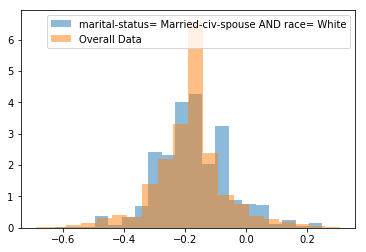

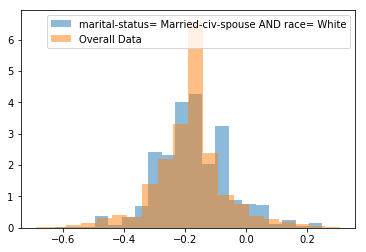

In [12]:
ps.plot_distribution_numeric(result[0][1], train_flip, bins=20)

In [13]:
# sgs = [x[1] for x in result]
# ps.compare_distributions_numeric(sgs, train_flip, bins=10)